# Project 3: Reddit NLP - Random Forest

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import time
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# I really like this color, so it will be used for everything
DO = '#7D1B7E'

%matplotlib inline
plt.style.use('fivethirtyeight')

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


I am now going to attempt to classify the subreddit posts by utilizing a TF-IDF alongside a Random Forest classifier.

Loading dataframe, stop words, train/test split datasets:

In [2]:
with open('../assets/df.pkl','rb') as f:
    df = pickle.load(f)
with open('../assets/stop_words_updated.pkl', 'rb') as f:
    stop_words = pickle.load(f)
with open('../assets/X_train.pkl', 'rb') as f: 
    X_train = pickle.load(f)
with open('../assets/X_test.pkl', 'rb') as f:
    X_test = pickle.load(f)
with open('../assets/y_train.pkl', 'rb') as f:
    y_train = pickle.load(f)
with open('../assets/y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)

In [3]:
df.head()

,selftext,subreddit,dating,token,word_count,char_count,clean_token
0,The beginning We have been in a monogamous r...,relationship_advice,0,"[beginning, we, monogamous, relationship, year...",1019,8921,beginning we monogamous relationship year shy ...
1,We have been together months It was a norma...,relationship_advice,0,"[we, together, months, normal, night, she, got...",97,777,we together months normal night she got shower...
2,Im a year old college student never been o...,dating,1,"[im, year, old, college, student, never, date,...",51,461,im year old college student never date done an...
3,Gf and I both been dating for months and...,relationship_advice,0,"[gf, i, dating, months, weve, pretty, good, re...",193,1797,gf i dating months weve pretty good relationsh...
4,Ok some background Bf and I have been togeth...,relationship_advice,0,"[ok, background, bf, i, together, years, short...",168,1360,ok background bf i together years shortly we f...


## TF-IDF

$$
\mathrm{tfidf}(t,d,D) = \frac{N_\text{term}}{N_\text{terms in Document}} \cdot \log\frac{N_\text{Documents}}{N_\text{Documents that contain term}}
$$

The TF-IDF consists of two parts, the Term Frequency and the Inverse Document Frequency, that provides a weight of how important a particular word is accross the corpus, which is the whole collection of documents.

## Random Forest - RandomizedSearchCV

A Random Forest classifier will use the dataset after it has been fit through TF-IDF. 

In random forests, each tree in the ensemble is built from a sample drawn with replacement (i.e., a bootstrap sample) from the training set. In addition, when splitting a node during the construction of the tree, the split that is chosen is no longer the best split among all features. Instead, the split that is picked is the best split among a random subset of the features. As a result of this randomness, the bias of the forest usually slightly increases (with respect to the bias of a single non-random tree) but, due to averaging, its variance also decreases, usually more than compensating for the increase in bias, hence yielding an overall better model.

[(Source)](https://scikit-learn.org/stable/modules/ensemble.html#forest)

As a result, the objective of the random classifier is to extract which words are most effective in predicting the correct class and also provide a confidence measure with the predictions.

A `RandomizedSearchCV` with the hyperparameters for the Random Forest will be implemented to return the optimal model. A `RandomizedSearchCV` will randomly choose a combination of parameters rather than looking through every combination of parameters. It will be used instead of a `GridSearchCV` due to computation time.

`n_estimators`
- Number of trees in the forest
- The default is 100, and the higher the number, the less likelihood that the model will overfit to the training data
- Also, the higher the number, the higher the number of votes for the correct class, which makes predictions more stable.

`max_depth`
- Max number of levels in each decision tree
- The default is None, which means the decision tree splits on every node until each leaf node is 100% pure.
- There is a high risk of overfitting to the training data.

`max_features`
- Max number of features that are considered at every decision node to split a node
- Typically the number of max_features should be less than all the features in the dataset.
- The higher number of max features also results in a high risk of overfitting.


`min_samples_split`
- Min number of samples required to split a decision node
- Default is 2

`min_samples_leaf`
- Min number of data points allowed in a leaf node
- Default is 1


In [4]:
X_train.head()

3934     In the past we would have sex regularly and so...
3348     Im going on a second with my crush and she did...
16190    Well my wife and I have been married for close...
15034    Anyways she works at the gym I go to in the ev...
7826     i already know somethings are very different  ...
Name: selftext, dtype: object

In [58]:
pipe = Pipeline([
                ('tf', TfidfVectorizer(stop_words = stop_words)),
                ('rf', RandomForestClassifier(random_state = 42))
])

In [59]:
parameters = {
    'rf__n_estimators':[100, 150, 200],
    'rf__max_depth': [None, 50, 100],
    'rf__max_features': ['auto', 10, 20, 50],
    'rf__min_samples_split':[2, 25, 40, 50, 70],
    'rf__min_samples_leaf': [1]
}

rscv = RandomizedSearchCV(pipe, 
                        param_distributions = parameters, 
                        return_train_score = True,
                        n_iter = 50,
                        cv = 3
                         )

In [60]:
rscv.fit(X_train, y_train)

34212.66879987717
35377.31409406662


In [61]:
rscv.best_params_

{'rf__n_estimators': 200,
 'rf__min_samples_split': 25,
 'rf__min_samples_leaf': 1,
 'rf__max_features': 'auto',
 'rf__max_depth': 100}

In [62]:
rscv_train_accuracy = round(rscv.score(X_train, y_train),3)
rscv_test_accuracy = round(rscv.score(X_test, y_test),3)

print(f'Train Accuracy: {rscv_train_accuracy}')
print(f'Test Accuracy: {rscv_test_accuracy}')

Train Accuracy: 0.992
Test Accuracy: 0.796


Based on the optimal parameters, the random forest classifier has high variance and low bias. The model accurately classified 99.2% of the training dataset but only classified 79.6% for the test dataset which implies that the model is highly overfit. A remedy might be to reduce the depth of trees as well as increase the number of decision trees.

The accuracy scores are similar to the logistic model.

## Feature Importance

I am now going to explore which words are the most important in gaining information and thus classification.

Obtaining the feature weights:

In [135]:
feature_weights = rscv.best_estimator_.named_steps['rf'].feature_importances_

Grabbing the top feature names and storing it as `vocab`.

In [97]:
vocab = rscv.best_estimator_.named_steps['tf'].get_feature_names()

Creating a feature importance dataframe

In [98]:
feature_df = pd.DataFrame( {'top_words': vocab, 'importance' : feature_weights})

In [99]:
feature_df = feature_df.set_index('top_words')
feature_df = feature_df.sort_values('importance',ascending = False)

In [100]:
feature_df.head(5)

,importance
top_words,
him,0.010355
my,0.009846
his,0.008492
he,0.008453
we,0.008200


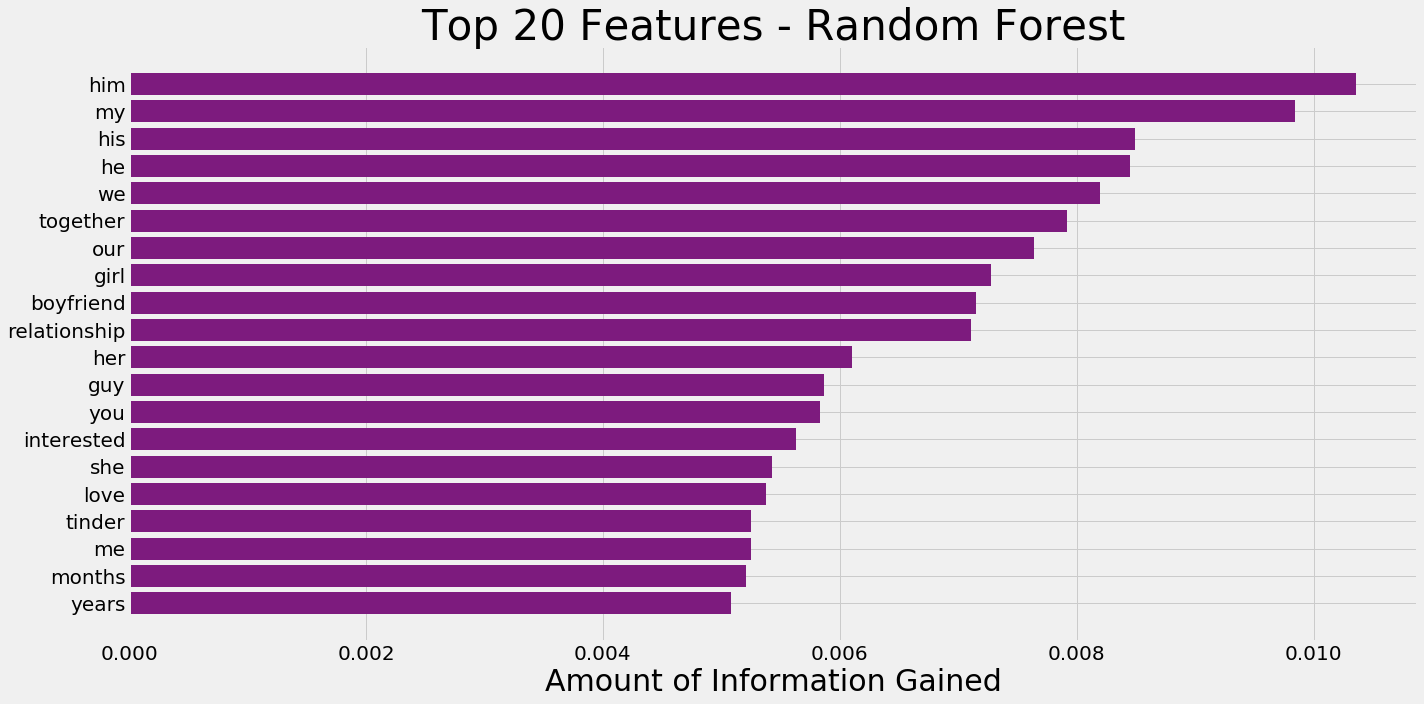

In [141]:
weights = feature_df['importance'].head(20).sort_values()
labels = weights.index

plt.figure(figsize=(20,10))
plt.barh(labels, weights, color = DO)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Amount of Information Gained', fontsize=30)
plt.title(f'Top 20 Features - Random Forest', fontsize=42)
plt.tight_layout()

plt.savefig('../plots/top_feature_RF_pres.png')

The features that provide the most information gained indicate how effective the features are at classifying the posts as the target class, the dating subreddit. 

The top words are gender pronouns, and it is interesting to see how `'him'`, `'his'`, and `'he'` are the top, perhaps suggesting that the majority of the posters have issues with their male significant other.

## Classification Metrics

The test accuracy score for the random search random forest is 79.6%. 

I will generate a confusion matrix on our test data because I want to examine how the random forest will perform on unseen data, ie checking whether posts are correctly or incorrectly classified from the dating subreddit.

In [124]:
y_pred = rscv.predict(X_test)

In [125]:
cm_def = np.array([['True Negative', 'False Positive'],
                ['False Negative', 'True Positive']])
cm_def = pd.DataFrame(cm_def,columns = ['pred neg', 'pred pos'], index = ['actual neg','actual pos'])

In [126]:
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, columns = ['pred neg', 'pred pos'], index = ['actual neg','actual pos'])

In [127]:
from IPython.display import display
display(cm_def)
display(cm_df)

,pred neg,pred pos
actual neg,True Negative,False Positive
actual pos,False Negative,True Positive


,pred neg,pred pos
actual neg,2399,456
actual pos,618,1789


In [128]:
len(X_test)

5262

Out of 5262 unseen dating and relationship_advice subreddit submissions:

**True Positives** - 1789
- Our model correctly predicted that 1789 posts are from the dating subreddit

**True Negatives** - 2399
- Our model correctly predicted that 2399 posts are from the relationship_advice subreddit

**False Positive** - 456
- Our model incorrectly predicted that 456 posts are from the dating subreddit. 

**False Negative** - 618
- Our model incorrectly predicted that 618 posts are from the relationship_advice subreddit

Given that the number of false positives and false negatives are roughly similar and that the true positives and true negatives are similar as well, the model only shows a slight bias towards the majority class which is the relationship_advice subreddit. 

Compared to the logistic classification model, there are 226 fewer true positive predictions, which is not ideal because we want to increase the number of true positive predictions.

## AUC ROC CURVE

Again, using the AUC ROC curve I will examine how well our model classifies the subreddit posts as 1's (dating) and 0's (relationship_advice).

In [130]:
pred_proba = rscv.predict_proba(X_test)[:,1]

In [131]:
pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})

Calculating the AUC ROC score.

In [134]:
auc_roc_score = round(roc_auc_score(pred_df['true_values'], pred_df['pred_probs']),2)
auc_roc_score

0.87

The AUC ROC score is 87% which is quite good and shows that there is not much overlap between our positive and negative classes.

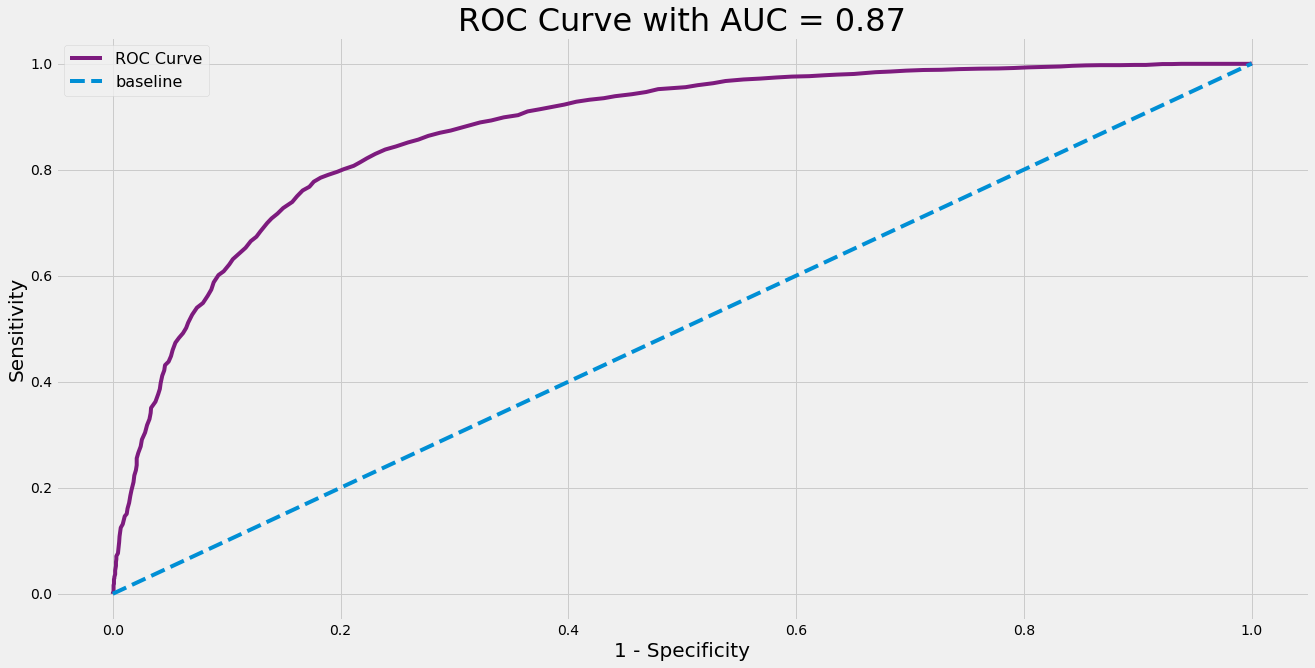

In [133]:
# Create figure.
plt.figure(figsize = (20,10))

# Create threshold values. (Dashed red line in image.)
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    
# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve',
        color = DO)

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f'ROC Curve with AUC = {auc_roc_score}', fontsize=32)
plt.ylabel('Sensitivity', fontsize=20)
plt.xlabel('1 - Specificity', fontsize=20)

# Create legend.
plt.legend(fontsize=16);

The blue dashed baseline indicates a perfect overlap between the dating and relationship_advice subreddit.

The ROC curve is generated by varying the classification threshold from 0 to 1. The curve provides a visualization of the tradeoff between sensitivity and specificity.

Through the random forest classification model, the subreddit populations are well-separated.

The sensitivity is how many posts did the model get correct out of all dating posts.

In [122]:
sensitivity = round(len(pred_df[(pred_df['true_values'] == 1) & (pred_df['pred_probs'] >= 0.5)])/len(pred_df[pred_df['true_values'] == 1]),2)
sensitivity

0.74

The sensitivity rate is 74%.

The specificity is how many posts did the mdoel get correct out of all the relationship_advice posts.

In [123]:
specificity = round(len(pred_df[(pred_df['true_values'] == 0) & (pred_df['pred_probs'] <= 0.5)])/len(pred_df[pred_df['true_values'] == 0]),2)
specificity

0.84

The specificity rate is 84%.

## Summary:

| Model | Train Accuracy | Test Accuracy | AUC ROC | True Positive | True Negative | False Positive | False Negative |
|---|---|---|---|---|---|---|---|
| Logistic Classification | 87% | <font color = 'red'> 82% | <font color = 'red'> 90% |2015 | 2320 | 535 | 392 |  
| Multinomial Naive Bayes | 83% |  81% | 89% | 1889 | 2370 | 485 | 418 |
| Random Forests | 99% | 80% | 87% | 1789 | 2399 | 456 | 618 |
    
Based on the test accuracy and AUC ROC scores, it appears the logistic classification model performed the best out of the three. Furthermore, there is easier interpretability in logistic model's feature weights, and the model is not as overfit as the random forest and only slightly more overfit compared to the multinomial naive bayes.

I will now examine the top features used in context of the posts and run a sentiment analysis to investigate which subreddit exhibits a greater plea for help.

# Proceed to Notebook 4: Sentiment Analysis